In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits

import scipy.stats

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp


from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

In [100]:
plt.style.use('notebook')

## Load catalog & definitions

In [3]:
t = Table.read('/home/ana/data/rcat_V2.1_MSG.fits')
ind = np.isfinite(t['GAIADR2_PMRA']) & (t['FLAG']==0) & (t['SNR']>10) & (t['E_tot_pot1']<0)
t = t[ind]
print(len(t))

age = 10**t['logAge']*1e-9
age_lerr = age - 10**(t['logAge']-t['logAge_lerr'])*1e-9
age_uerr = 10**(t['logAge']+t['logAge_uerr'])*1e-9 - age
age_err = 0.5 * (age_lerr + age_uerr)
age_err_cons = np.maximum(age_lerr, age_uerr)
age_err_min = 1
age_err_cons[age_err_cons<age_err_min] = age_err_min
age_invar = (age_err_cons)**-2

/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


27962


In [4]:
# blue = '#0039d3'
# purple = '#4700d3'
# orange = '#ff6200'
# pink = '#ee0449'

blue = '#0043c7'
orange = '#db3700'
gold = '#ffa006'

In [5]:
ind_all = np.ones(len(t), dtype='bool')
ind_z = (np.abs(t['Z_gal'])<1)
loggmin, loggmax = 3.8, 4.3
ind_safeage = (t['logg']>loggmin) & (t['logg']<loggmax) #& (t['logg_err']<0.1)
# ind_safeage = (t['logg']>3.8) & (t['logg']<4.3) & (age_err/age<0.15)
print(np.sum(ind_safeage))

11034


In [6]:
ind_highe = (t['eccen_pot1']>0.75)
ind_lowe = (t['eccen_pot1']<0.25)

p_ge = [-0.32,-0.02]
poly_ge = np.poly1d(p_ge)

p_splash = [-0.14,0.18]
poly_splash = np.poly1d(p_splash)

p_lowa = [-0.14,0.15]
poly_lowa = np.poly1d(p_lowa)

ind_lowachem = (t['init_FeH']>-0.45) & (t['init_aFe']<poly_lowa(t['init_FeH']))
ind_lowa = ind_lowe & ind_lowachem

ind_mpoor = (t['init_FeH']<-0.6) & (t['init_aFe']<poly_ge(t['init_FeH']))
ind_ge = ind_mpoor & ind_highe

ind_tdchem = (t['init_FeH']>-0.75) & (t['init_aFe']>poly_splash(t['init_FeH']))
ind_splash = ind_tdchem & ind_highe
ind_thick = ind_tdchem & (t['eccen_pot1']<0.5)

## Alternative potential

In [15]:
print(t.colnames)

['starname', 'tileID', 'selID', 'dateID', 'fibID', 'redID', 'pipeID', 'H3_ID', 'TMASS_ID', 'GAIADR2_ID', 'UNWISE_ID', 'RA', 'DEC', 'RA_S', 'DEC_S', 'GAIADR2_RA', 'GAIADR2_RA_ERROR', 'GAIADR2_DEC', 'GAIADR2_DEC_ERROR', 'L', 'B', 'xfocal', 'yfocal', 'CCDTEMP', 'mjd', 'night', 'RAND', 'GUIDE', 'XFIT_RANK', 'MGIANT', 'BHB', 'EBV', 'APOPAYNE_RA', 'APOPAYNE_DEC', 'APOPAYNE_ID', 'APOPAYNE_TEFF', 'APOPAYNE_LOGG', 'APOPAYNE_VMIC', 'APOPAYNE_VMAC', 'APOPAYNE_FEH', 'APOPAYNE_CH', 'APOPAYNE_NH', 'APOPAYNE_OH', 'APOPAYNE_MGH', 'APOPAYNE_ALH', 'APOPAYNE_SIH', 'APOPAYNE_SH', 'APOPAYNE_KH', 'APOPAYNE_CAH', 'APOPAYNE_TIH', 'APOPAYNE_CRH', 'APOPAYNE_MNH', 'APOPAYNE_NIH', 'APOPAYNE_CUH', 'APOPAYNE_C12C13', 'APOPAYNE_CHI2_R', 'APOPAYNE_QUALITY_FLAG', 'APOPAYNE_DMATCH', 'LAMOST_RA', 'LAMOST_DEC', 'LAMOST_ID', 'LAMOST_SPECCLASS', 'LAMOST_SUBCLASS', 'LAMOST_SNRG', 'LAMOST_SNRR', 'LAMOST_TEFF', 'LAMOST_TEFF_ERR', 'LAMOST_LOGG', 'LAMOST_LOGG_ERR', 'LAMOST_FEH', 'LAMOST_FEH_ERR', 'LAMOST_RV', 'LAMOST_RV_ERR', '

In [16]:
c = coord.SkyCoord(ra=t['GAIADR2_RA']*u.deg, dec=t['GAIADR2_DEC']*u.deg, distance=t['dist_adpt']*u.kpc,
                   pm_ra_cosdec=t['GAIADR2_PMRA']*u.mas/u.yr, pm_dec=t['GAIADR2_PMDEC']*u.mas/u.yr,
                   radial_velocity=t['Vrad']*u.km/u.s, frame='icrs')

In [63]:
ham = gp.Hamiltonian(gp.BovyMWPotential2014())
ham_default = gp.Hamiltonian(gp.MilkyWayPotential())

In [23]:
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [24]:
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

In [114]:
cgal = coord.Galactocentric(x=t['X_gal']*u.kpc, y=t['Y_gal']*u.kpc, z=t['Z_gal']*u.kpc,
                           v_x=t['Vx_gal']*u.km/u.s, v_y=t['Vy_gal']*u.km/u.s, v_z=t['Vz_gal']*u.km/u.s)
w0 = gd.PhaseSpacePosition(cgal.cartesian)

In [115]:
np.shape(w0)

(27962,)

In [116]:
i = 0

In [133]:
dt = 0.5*u.Myr
tmax = 5*u.Gyr
n_steps = int(tmax/dt)

In [139]:
orbit = ham_default.integrate_orbit(w0[ind_safeage][i], dt=dt, n_steps=n_steps)

In [140]:
orbit.eccentricity(), t['eccen_pot1'][ind_safeage][i]

(<Quantity 0.18823594>, 0.18662027358263525)

In [141]:
Nmsto = np.sum(ind_safeage)
ecc = np.empty(Nmsto)
ecc_default = np.empty(Nmsto)

In [145]:
for i in range(Nmsto):
    orbit = ham.integrate_orbit(w0[ind_safeage][i], dt=dt, n_steps=n_steps)
    ecc[i] = orbit.eccentricity()

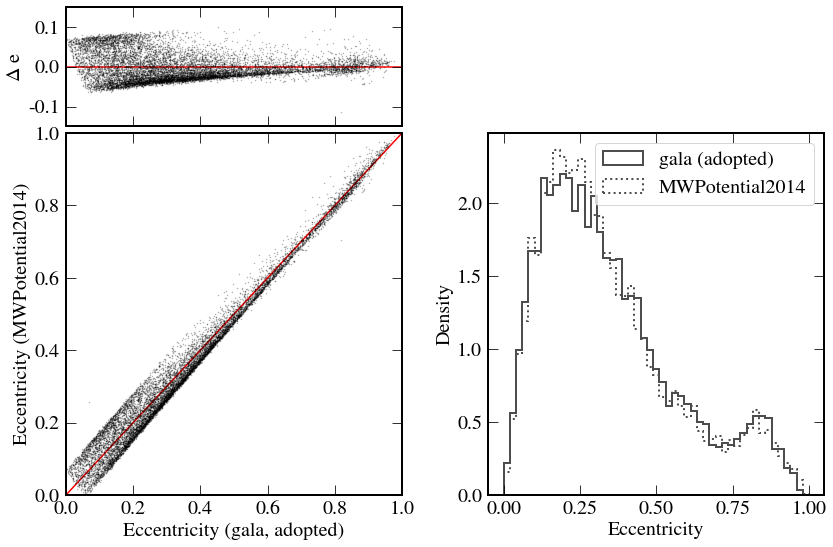

In [212]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex='col', gridspec_kw=dict(height_ratios=(0.33,1)))

plt.sca(ax[0][0])
plt.plot(t['eccen_pot1'][ind_safeage], ecc - t['eccen_pot1'][ind_safeage], 'k.', ms=1, alpha=0.3)
plt.axhline(0, color='r', zorder=0)
# plt.axhline(0.02, color='r', zorder=0)
# plt.axhline(-0.02, color='r', zorder=0)

plt.ylim(-0.15,0.15)
plt.xlim(0,1)
plt.ylabel('$\Delta$ e')


plt.sca(ax[1][0])
plt.plot(t['eccen_pot1'][ind_safeage], ecc, 'k.', ms=1, alpha=0.3)
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), 'r-', zorder=0)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Eccentricity (gala, adopted)')
plt.ylabel('Eccentricity (MWPotential2014)')

plt.sca(ax[0][1])
plt.axis('off')

plt.sca(ax[1][1])
ebins = np.linspace(0,1,50)
plt.hist(t['eccen_pot1'][ind_safeage], bins=ebins, lw=2, color='0.3', histtype='step', density=True,
         label='gala (adopted)')
plt.hist(ecc, bins=ebins, lw=2, color='0.3', ls=':', histtype='step', density=True, label='MWPotential2014')

plt.legend()
plt.xlabel('Eccentricity')
plt.ylabel('Density')

plt.tight_layout(h_pad=0)
plt.savefig('../paper/ecc_comparison.png')

In [200]:
ind_lowa_alt = ind_lowachem[ind_safeage] & (ecc<0.25)
ind_thick_alt = ind_tdchem[ind_safeage] & (ecc<0.5)
ind_splash_alt = ind_tdchem[ind_safeage] & (ecc>0.75)
ind_ge_alt = ind_mpoor[ind_safeage] & (ecc>0.75)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [213]:
z = np.array([0.5,1,2,5,10])
zlabel = [('%f' % x).rstrip('0').rstrip('.') for x in z]
lookback = cosmo.lookbackTime(z)

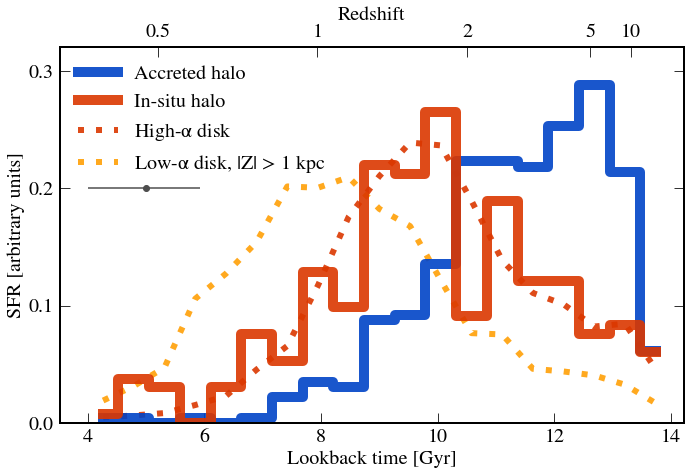

In [202]:
ivar = age_err**-1
ivar = np.ones_like(age_err)
abins = np.linspace(4,14,20)
# abins = np.linspace(3,15,22)
abcen = 0.5 * (abins[1:] + abins[:-1])

h_accreted, be = np.histogram(age[ind_safeage][ind_ge_alt], bins=abins, density=True)
h_insitu, be = np.histogram(age[ind_safeage][ind_splash_alt], bins=abins, density=True)
h_higha, be = np.histogram(age[ind_safeage][ind_thick_alt], bins=abins, density=True)
h_lowa, be = np.histogram(age[ind_safeage][ind_lowa_alt], bins=abins, density=True)

plt.figure(figsize=(10,7))

plt.plot(abcen, h_accreted, color=blue, lw=10, alpha=0.9, drawstyle='steps-mid', label='Accreted halo')
plt.plot(abcen, h_insitu, color=orange, lw=10, alpha=0.9, drawstyle='steps-mid', label='In-situ halo')
plt.plot(abcen, h_higha, color=orange, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='High-$\\alpha$ disk')
plt.plot(abcen, h_lowa, color=gold, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='Low-$\\alpha$ disk, |Z| > 1 kpc')

plt.errorbar(np.array([5]), np.array([0.2]), yerr=None,
             xerr=np.array([np.median(age_lerr[ind_safeage]), np.median(age_uerr[ind_safeage])])[:,np.newaxis],
             fmt='o', color='0.3', capsize=0)

plt.ylim(0,0.32)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend(loc=2, frameon=False )
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [arbitrary units]')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(lookback)
ax2.set_xticklabels(zlabel)
ax2.set_xlabel('Redshift')

plt.tight_layout()
plt.savefig('../paper/ages_mwpotential2014.png')

## Repositioned legend

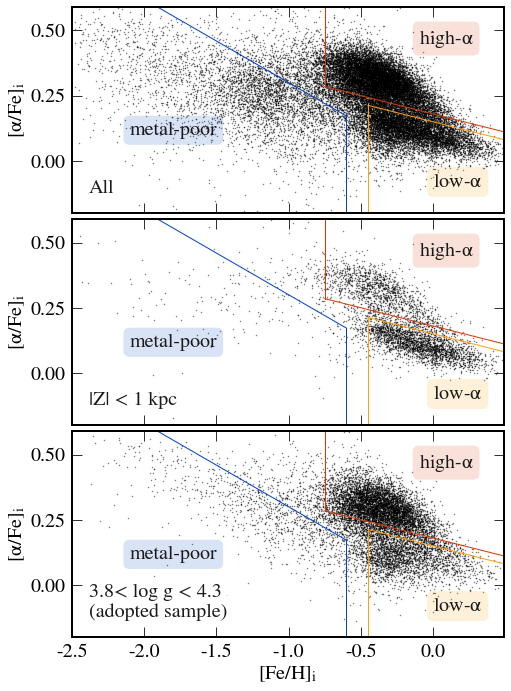

In [18]:
x_ge = np.linspace(-2, -0.6, 30)
y_ge = poly_ge(x_ge)

x_splash = np.linspace(-0.75, 0.5, 30)
y_splash = poly_splash(x_splash)

x_lowa = np.linspace(-0.45, 0.5, 30)
y_lowa = poly_lowa(x_lowa)

afeh_panels = ['All', '|Z| < 1 kpc', '{:.1f}< log g < {:.1f}\n(adopted sample)'.format(loggmin, loggmax)]
lw = 1

fig, ax = plt.subplots(3,1,figsize=(7.5,10), sharex=True, sharey=True)

for e, ind in enumerate([ind_all, ind_z, ind_safeage]):
    plt.sca(ax[e])
    plt.plot(t['init_FeH'][ind], t['init_aFe'][ind], 'ko', mew=0, ms=1.5, alpha=0.5, rasterized=True, zorder=0)

    plt.plot(x_ge, y_ge, '-', color=blue, label='', lw=lw)
    plt.plot([-0.6, -0.6], [-0.2, poly_ge(-0.6)], '-', color=blue, label='', lw=lw)
    plt.plot(x_splash, y_splash, '-', color=orange, label='', lw=lw)
    plt.plot([-0.75, -0.75], [poly_splash(-0.75), 0.6], '-', color=orange, label='', lw=lw)
    plt.plot(x_lowa, y_lowa, '-', color=gold, label='', lw=lw)
    plt.plot([-0.45, -0.45], [-0.2, poly_lowa(-0.5)], '-', color=gold, label='', lw=lw)
    
    plt.text(-0.1, 0.45, 'high-$\\alpha$', color='0.1',
         bbox=dict(facecolor=orange, ec='none', alpha=0.15, boxstyle='round', pad=0.3))
    plt.text(0, -0.1, 'low-$\\alpha$', color='0.1',
         bbox=dict(facecolor=gold, ec='none', alpha=0.15, boxstyle='round', pad=0.3))
    plt.text(-2.1, 0.1, 'metal-poor', color='0.1',
             bbox=dict(facecolor=blue, ec='none', alpha=0.15, boxstyle='round', pad=0.3))

    plt.text(0.04, 0.08, afeh_panels[e], color='0.1', transform=plt.gca().transAxes, va='bottom',
             bbox=dict(facecolor='w', ec='none', alpha=0.75, boxstyle='round', pad=0.3))
    plt.ylabel('[$\\alpha$/Fe]$_i$')

plt.xlim(-2.5,0.49)
plt.ylim(-0.2, 0.59)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
plt.xlabel('[Fe/H]$_i$')
plt.tight_layout(h_pad=0.3)
plt.savefig('../paper/afeh_selections.pdf')

## Guidelines in figure 3

In [54]:
cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846]]

In [55]:
parula_map = mpl.colors.LinearSegmentedColormap.from_list('parula', cm_data[::-1])

In [56]:
x_ge = np.linspace(-2, -0.6, 30)
y_ge = poly_ge(x_ge)

x_splash = np.linspace(-0.75, 0.5, 30)
y_splash = poly_splash(x_splash)

x_lowa = np.linspace(-0.45, 0.5, 30)
y_lowa = poly_lowa(x_lowa)

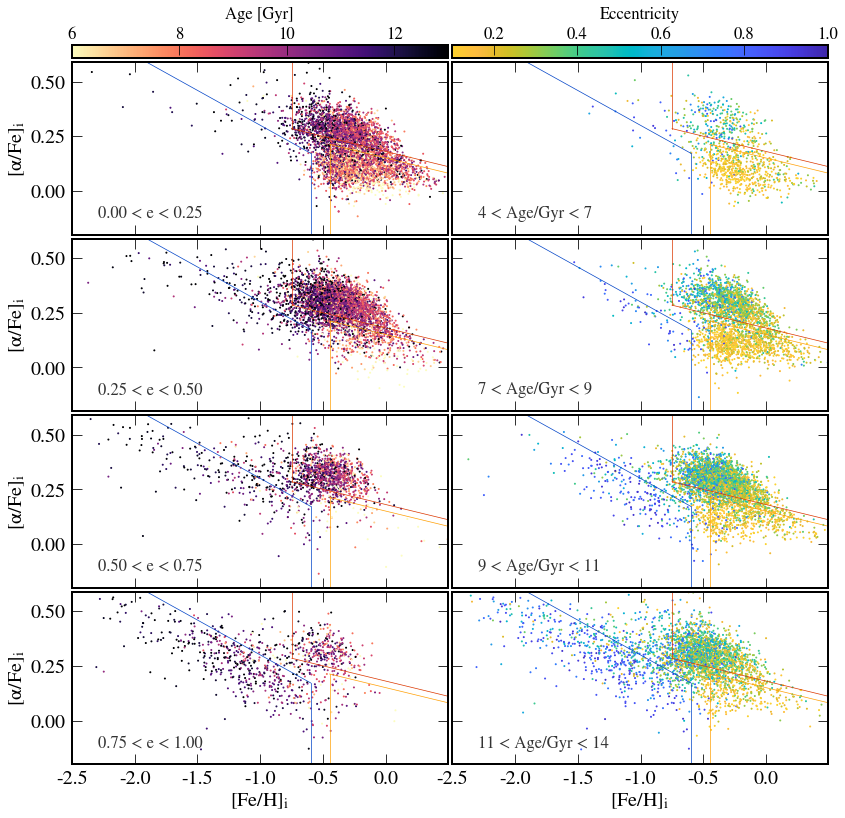

In [57]:
ecc_ranges = np.array([0,0.25,0.5,0.75,1])
age_ranges = np.array([4,7,9,11,14])
Ne = np.size(ecc_ranges) - 1

lw = 0.7
da = 6
fig, ax = plt.subplots(Ne,2,figsize=(12,11), sharey=True, sharex=True)

for i in range(Ne):
    ind = (t['eccen_pot1']>=ecc_ranges[i]) & (t['eccen_pot1']<ecc_ranges[i+1])
    
    # left column
    plt.sca(ax[i][0])
    cmap0 = 'magma_r'
    ima = plt.scatter(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], c=age[ind_safeage & ind],
               vmin=6, vmax=13, cmap=cmap0, rasterized=True, s=1, alpha=1)
    
    plt.xlim(-2.5,0.49)
    plt.ylabel('[$\\alpha$/Fe]$_i$')
    plt.text(0.07,0.1,'{:.2f} < e < {:.2f}'.format(ecc_ranges[i], ecc_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
    # right column
    plt.sca(ax[i][1])
    ind = (age>=age_ranges[i]) & (age<age_ranges[i+1])
    cmap = parula_map
    ime = plt.scatter(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind],
                c=t['eccen_pot1'][ind_safeage & ind],
               vmin=0.1, vmax=1, cmap=cmap, rasterized=True, s=1, alpha=1)
    
    plt.text(0.07,0.1,'{:.0f} < Age/Gyr < {:.0f}'.format(age_ranges[i], age_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
    for j in range(2):
        plt.sca(ax[i][j])
        plt.plot(x_ge, y_ge, '-', color=blue, label='', lw=lw)
        plt.plot([-0.6, -0.6], [-0.2, poly_ge(-0.6)], '-', color=blue, label='', lw=lw)
        plt.plot(x_splash, y_splash, '-', color=orange, label='', lw=lw)
        plt.plot([-0.75, -0.75], [poly_splash(-0.75), 0.6], '-', color=orange, label='', lw=lw)
        plt.plot(x_lowa, y_lowa, '-', color=gold, label='', lw=lw)
        plt.plot([-0.45, -0.45], [-0.2, poly_lowa(-0.45)], '-', color=gold, label='', lw=lw)
        
        plt.xlim(-2.5,0.49)
        plt.ylim(-0.2, 0.59)
        plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))


for j in range(2):
    plt.sca(ax[Ne-1][j])
    plt.xlabel('[Fe/H]$_i$')
  
plt.tight_layout(w_pad=0.2, h_pad=0.2)
cmap = 'parula'

plt.sca(ax[0][0])
pos = plt.gca().get_position()
cax_age = plt.axes([pos.x0, pos.y1+0.005, pos.x1 - pos.x0, 0.017])
plt.colorbar(ima, cax=cax_age, orientation='horizontal', ticks=[4,6,8,10,12])
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize='small', y=0.7)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Age [Gyr]', fontsize='small', labelpad=8)

plt.sca(ax[0][1])
pos = plt.gca().get_position()
cax_ecc = plt.axes([pos.x0, pos.y1+0.005, pos.x1 - pos.x0, 0.017])
cbar = plt.colorbar(ime, cax=cax_ecc, orientation='horizontal', ticks=np.arange(0.2,1.1,0.2))
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize='small', y=0.7)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Eccentricity', fontsize='small', labelpad=8)

plt.savefig('../paper/afeh_eccen_age_guides.pdf')

## Different selections

In [ ]:
ind_highe = (t['eccen_pot1']>0.75)
ind_lowe = (t['eccen_pot1']<0.25)

p_ge = [-0.32,-0.02]
poly_ge = np.poly1d(p_ge)

p_splash = [-0.14,0.18]
poly_splash = np.poly1d(p_splash)

p_lowa = [-0.14,0.15]
poly_lowa = np.poly1d(p_lowa)

ind_lowachem = (t['init_FeH']>-0.45) & (t['init_aFe']<poly_lowa(t['init_FeH']))
ind_lowa = ind_lowe & ind_lowachem

ind_mpoor = (t['init_FeH']<-0.6) & (t['init_aFe']<poly_ge(t['init_FeH']))
ind_ge = ind_mpoor & ind_highe

ind_tdchem = (t['init_FeH']>-0.75) & (t['init_aFe']>poly_splash(t['init_FeH']))
ind_splash = ind_tdchem & ind_highe
ind_thick = ind_tdchem & (t['eccen_pot1']<0.5)

In [ ]:
x_ge = np.linspace(-2, -0.6, 30)
y_ge = poly_ge(x_ge)

x_splash = np.linspace(-0.75, 0.5, 30)
y_splash = poly_splash(x_splash)

x_lowa = np.linspace(-0.45, 0.5, 30)
y_lowa = poly_lowa(x_lowa)


plt.plot(x_ge, y_ge, '-', color=blue, label='', lw=lw)
plt.plot([-0.6, -0.6], [-0.2, poly_ge(-0.6)], '-', color=blue, label='', lw=lw)
plt.plot(x_splash, y_splash, '-', color=orange, label='', lw=lw)
plt.plot([-0.75, -0.75], [poly_splash(-0.75), 0.6], '-', color=orange, label='', lw=lw)
plt.plot(x_lowa, y_lowa, '-', color=gold, label='', lw=lw)
plt.plot([-0.45, -0.45], [-0.2, poly_lowa(-0.5)], '-', color=gold, label='', lw=lw)

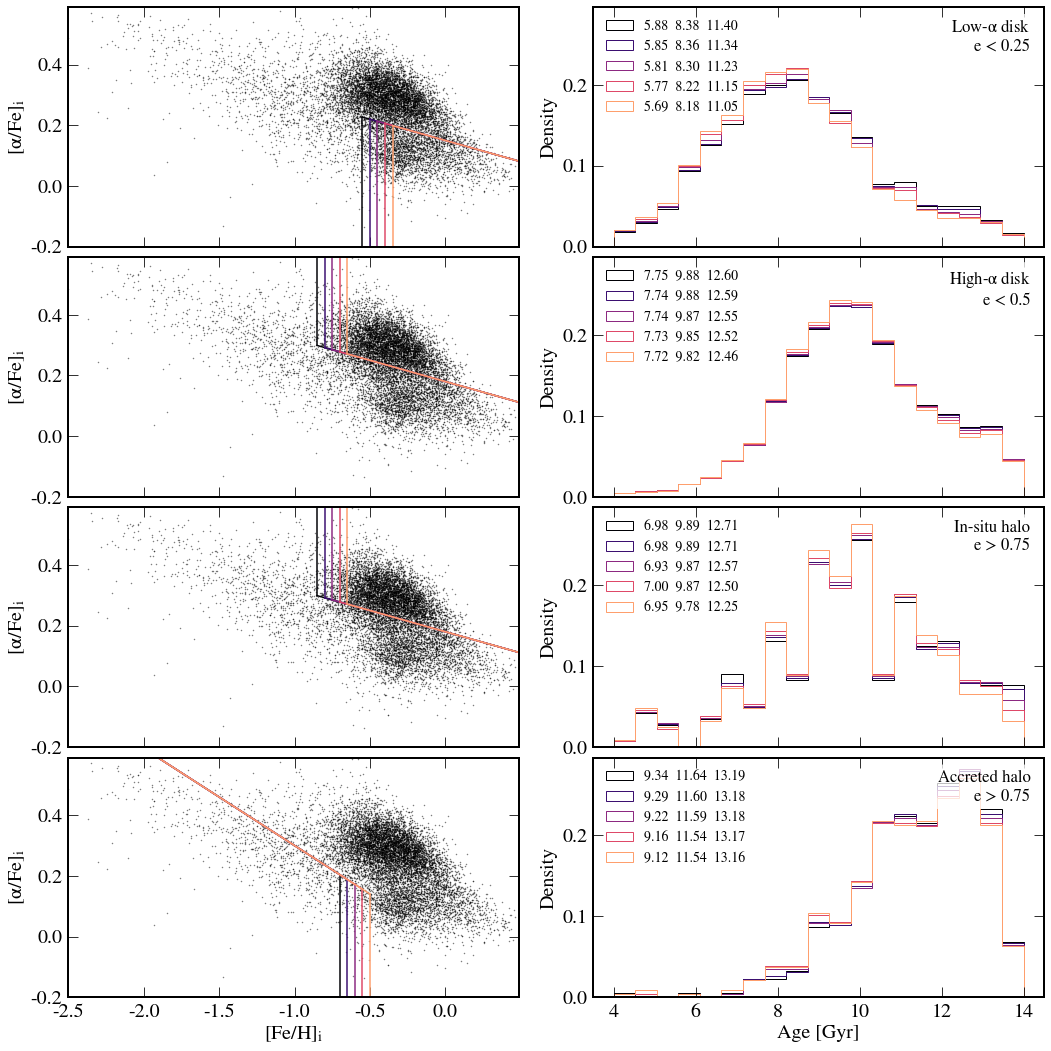

In [78]:
# feh_off = np.arange(-0.1,0.11,0.05)
feh_off = np.linspace(-0.1,0.1,5)
abins = np.linspace(4,14,20)
abcen = 0.5 * (abins[1:] + abins[:-1])

fig, ax = plt.subplots(4,2,figsize=(15,15), sharex='col', sharey='col')

for i in range(5):
    # Low-alpha disk
    plt.sca(ax[0][0])
    feh_cut = -0.45+feh_off[i]
    x_lowa = np.linspace(feh_cut, 0.5, 30)
    y_lowa = poly_lowa(x_lowa)
    plt.plot(x_lowa, y_lowa, '-', color=mpl.cm.magma(i/5), label='')
    plt.plot([feh_cut, feh_cut], [-0.2, poly_lowa(feh_cut)], '-', color=mpl.cm.magma(i/5), label='')
    
    plt.sca(ax[0][1])
    ind_lowa_alt = ind_lowe & (t['init_aFe']<poly_lowa(t['init_FeH'])) & (t['init_FeH']>-0.45+feh_off[i])
    plt.hist(age[ind_safeage & ind_lowa_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
            label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_lowa_alt], [10,50,90])))
      
    
    # High-alpha disk
    plt.sca(ax[1][0])
    feh_cut = -0.75 + feh_off[i]
    x_splash = np.linspace(feh_cut, 0.5, 30)
    y_splash = poly_splash(x_splash)
    plt.plot(x_splash, y_splash, '-', color=mpl.cm.magma(i/5), label='')
    plt.plot([feh_cut, feh_cut], [poly_splash(feh_cut), 0.6], '-', color=mpl.cm.magma(i/5), label='')
    
    plt.sca(ax[1][1])
    ind_thick_alt = ((t['eccen_pot1']<0.5) & (t['init_FeH']>-0.75+feh_off[i]) 
                     & (t['init_aFe']>poly_splash(t['init_FeH'])))
    plt.hist(age[ind_safeage & ind_thick_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
             label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_thick_alt], [10,50,90])))
    
    
    # In-situ halo
    plt.sca(ax[2][0])
    feh_cut = -0.75 + feh_off[i]
    x_splash = np.linspace(feh_cut, 0.5, 30)
    y_splash = poly_splash(x_splash)
    plt.plot(x_splash, y_splash, '-', color=mpl.cm.magma(i/5), label='')
    plt.plot([feh_cut, feh_cut], [poly_splash(feh_cut), 0.6], '-', color=mpl.cm.magma(i/5), label='')
    
    plt.sca(ax[2][1])
    ind_splash_alt = (ind_highe & (t['init_FeH']>-0.75+feh_off[i]) & (t['init_aFe']>poly_splash(t['init_FeH'])))
    plt.hist(age[ind_safeage & ind_splash_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
             label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_splash_alt], [10,50,90])))
    
    
    # Accreted halo
    plt.sca(ax[3][0])
    feh_cut = -0.6 + feh_off[i]
    x_ge = np.linspace(-2, feh_cut, 30)
    y_ge = poly_ge(x_ge)
    plt.plot(x_ge, y_ge, '-', color=mpl.cm.magma(i/5), label='')
    plt.plot([feh_cut, feh_cut], [-0.2, poly_ge(feh_cut)], '-', color=mpl.cm.magma(i/5), label='')

    plt.sca(ax[3][1])
    ind_ge_alt = ind_highe & (t['init_FeH']<-0.6+feh_off[i]) & (t['init_aFe']<poly_ge(t['init_FeH']))
    plt.hist(age[ind_safeage & ind_ge_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
             label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_ge_alt], [10,50,90])))
    
label = ['Low-$\\alpha$ disk', 'High-$\\alpha$ disk', 'In-situ halo', 'Accreted halo']
ecc_cut = ['< 0.25', '< 0.5', '> 0.75', '> 0.75']
    
for i in range(4):
    plt.sca(ax[i][0])
    plt.plot(t['init_FeH'][ind_safeage], t['init_aFe'][ind_safeage], 'ko',
             mew=0, ms=1.5, alpha=0.5, rasterized=True, zorder=0)
    
    plt.xlim(-2.5,0.49)
    plt.ylim(-0.2, 0.59)
    plt.ylabel('[$\\alpha$/Fe]$_{i}$')
    
    plt.sca(ax[i][1])
    plt.legend(loc=2,fontsize='x-small', ncol=1, frameon=False)
    plt.text(0.97,0.95, '{:s}\ne {:s}'.format(label[i], ecc_cut[i]),
             transform=plt.gca().transAxes, va='top', ha='right', fontsize='small',
             bbox=dict(facecolor='w', ec='none', alpha=0.75, boxstyle='round', pad=0.3))    
    plt.ylabel('Density')
    
    
plt.sca(ax[3][0])
plt.xlabel('[Fe/H]$_{i}$')
    
plt.sca(ax[3][1])
plt.xlabel('Age [Gyr]')
    
plt.tight_layout(h_pad=0)
plt.savefig('../plots/feh_cuts_ages.png')

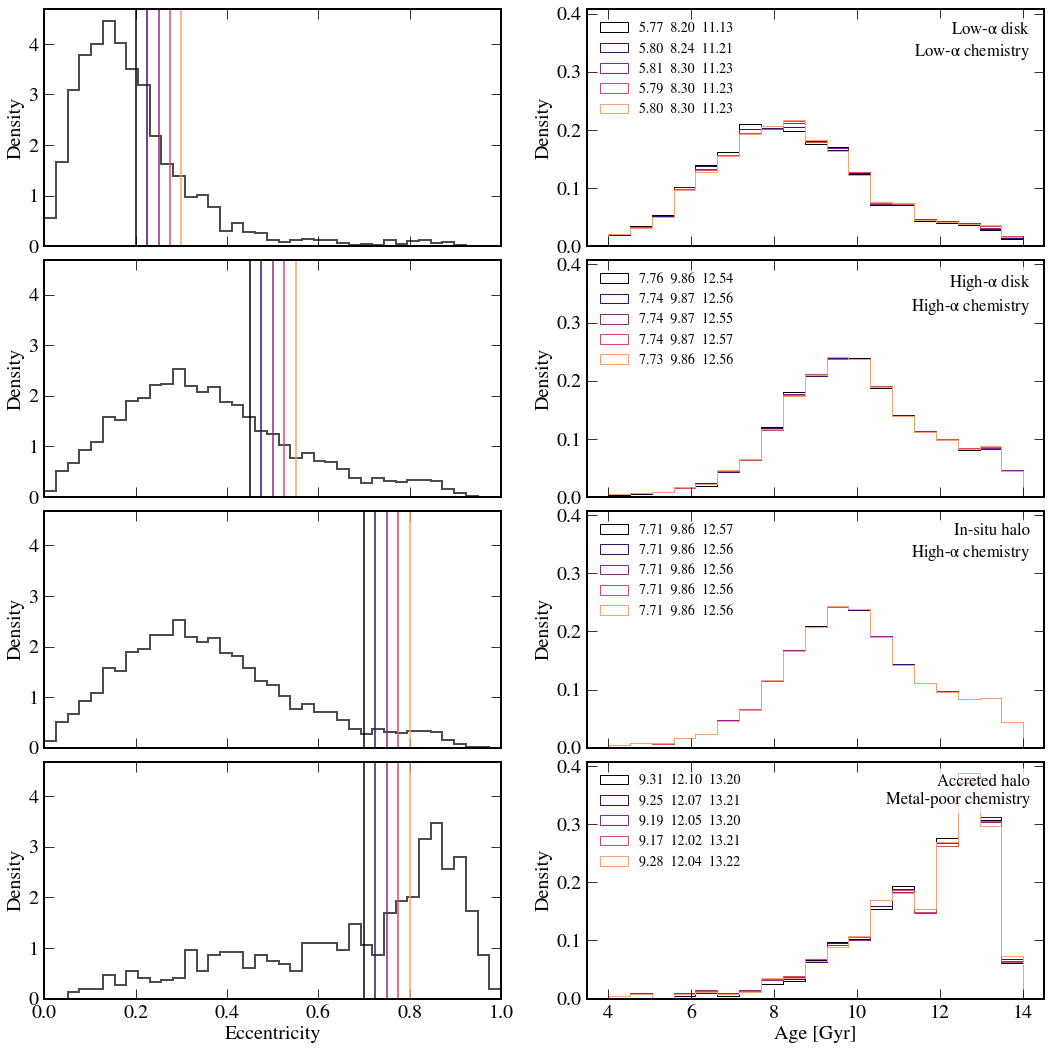

In [98]:
ecc_off = np.linspace(-0.05,0.05,5)
abins = np.linspace(4,14,20)
abcen = 0.5 * (abins[1:] + abins[:-1])

fig, ax = plt.subplots(4,2,figsize=(15,15), sharex='col', sharey='col')

for i in range(5):
    # Low-alpha disk
    plt.sca(ax[0][0])
    plt.axvline(0.25 + ecc_off[i], color=mpl.cm.magma(i/5))
    
    plt.sca(ax[0][1])
    ind_lowa_alt = (t['eccen_pot1']<0.25 + ecc_off[i]) & ind_lowachem
    plt.hist(age[ind_safeage & ind_lowa_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
            label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_lowa_alt], [10,50,90])))
      
    
    # High-alpha disk
    plt.sca(ax[1][0])
    plt.axvline(0.5 + ecc_off[i], color=mpl.cm.magma(i/5))
    
    plt.sca(ax[1][1])
    ind_thick_alt = ((t['eccen_pot1']<0.5 +ecc_off[i]) & ind_tdchem)
    plt.hist(age[ind_safeage & ind_thick_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
             label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_thick_alt], [10,50,90])))
    
    
    # In-situ halo
    plt.sca(ax[2][0])
    plt.axvline(0.75 + ecc_off[i], color=mpl.cm.magma(i/5))
    
    plt.sca(ax[2][1])
    ind_splash_alt = (t['eccen_pot1']<0.75 + ecc_off[i]) & ind_tdchem
    plt.hist(age[ind_safeage & ind_splash_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
             label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_splash_alt], [10,50,90])))
    
    
    # Accreted halo
    plt.sca(ax[3][0])
    plt.axvline(0.75 + ecc_off[i], color=mpl.cm.magma(i/5))

    plt.sca(ax[3][1])
    ind_ge_alt = (t['eccen_pot1']<0.75 + ecc_off[i]) & ind_mpoor
    plt.hist(age[ind_safeage & ind_ge_alt], bins=abins, color=mpl.cm.magma(i/5), density=True, histtype='step',
             label='{:.2f}  {:.2f}  {:.2f}'.format(*np.percentile(age[ind_safeage & ind_ge_alt], [10,50,90])))
    
label = ['Low-$\\alpha$ disk', 'High-$\\alpha$ disk', 'In-situ halo', 'Accreted halo']
chem_cut = ['Low-$\\alpha$', 'High-$\\alpha$', 'High-$\\alpha$', 'Metal-poor']

ebins = np.linspace(0,1,40)
ind_chem = [ind_lowachem, ind_tdchem, ind_tdchem, ind_mpoor]

for i in range(4):
    plt.sca(ax[i][0])
    plt.hist(t['eccen_pot1'][ind_safeage & ind_chem[i]], bins=ebins,
             histtype='step', color='k', alpha=0.7, lw=2, density=True)

    plt.xlim(0, 1)
    plt.ylabel('Density')
    
    plt.sca(ax[i][1])
    plt.legend(loc=2,fontsize='x-small', ncol=1, frameon=False)
    plt.text(0.97,0.95, '{:s}\n{:s} chemistry'.format(label[i], chem_cut[i]),
             transform=plt.gca().transAxes, va='top', ha='right', fontsize='small',
             bbox=dict(facecolor='w', ec='none', alpha=0.75, boxstyle='round', pad=0.3))    
    plt.ylabel('Density')
    
    
plt.sca(ax[3][0])
plt.xlabel('Eccentricity')
    
plt.sca(ax[3][1])
plt.xlabel('Age [Gyr]')
    
plt.tight_layout(h_pad=0)
plt.savefig('../plots/ecc_cuts_ages.png')